In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate_nn as srnn
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
warnings.filterwarnings('ignore')

In [8]:
L63_data_path = '../data/L63-trajectories'
N = 20
train = np.load(f'{L63_data_path}/train.npy')[:, :N].astype(np.float32)
test = np.load(f'{L63_data_path}/test.npy')[:, :, :1000].astype(np.float32)

model = srnn.SurrogateModel_NN(3, 300, name='test_model', save_folder='../data/test/test_model')
model.learn(train, steps=1000000, learning_rate=1e-2, drop=0.5)

step: 0    loss: 1041.552612     time elapsed=0.0008
step: 100    loss: 120.511719     time elapsed=0.0271
step: 200    loss: 2.209887     time elapsed=0.0462
step: 300    loss: 0.200203     time elapsed=0.0623
step: 400    loss: 2.121986     time elapsed=0.0790
step: 500    loss: 2.419961     time elapsed=0.0953
step: 600    loss: 3.210776     time elapsed=0.1115
step: 700    loss: 9.730260     time elapsed=0.1276
step: 800    loss: 2.455527     time elapsed=0.1436
step: 900    loss: 1.760381     time elapsed=0.1596
step: 1000    loss: 9.301492     time elapsed=0.1755
step: 1100    loss: 0.093212     time elapsed=0.1914
step: 1200    loss: 4.031847     time elapsed=0.2081
step: 1300    loss: 1.104551     time elapsed=0.2251
step: 1400    loss: 1.491505     time elapsed=0.2415
step: 1500    loss: 0.586393     time elapsed=0.2576
step: 1600    loss: 0.920382     time elapsed=0.2736
step: 1700    loss: 0.002038     time elapsed=0.2895
step: 1800    loss: 0.962053     time elapsed=0.3054


In [10]:
iters = list(range(0, 1000000, 10000))
tau = np.zeros(len(iters))
for i, iter in enumerate(iters):
    model.net = torch.load(f'../data/test/test_model/test_model_{iter}')
    tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
    tau[i] = tau_f_se.mean()
    print(i)

Time taken by compute_tau_f is 1.3268 seconds
0
Time taken by compute_tau_f is 1.2760 seconds
1
Time taken by compute_tau_f is 1.2623 seconds
2
Time taken by compute_tau_f is 1.2772 seconds
3
Time taken by compute_tau_f is 1.3106 seconds
4
Time taken by compute_tau_f is 1.2717 seconds
5
Time taken by compute_tau_f is 1.2677 seconds
6
Time taken by compute_tau_f is 1.2686 seconds
7
Time taken by compute_tau_f is 1.2659 seconds
8
Time taken by compute_tau_f is 1.2596 seconds
9
Time taken by compute_tau_f is 1.2701 seconds
10
Time taken by compute_tau_f is 1.2719 seconds
11
Time taken by compute_tau_f is 1.2649 seconds
12
Time taken by compute_tau_f is 1.2649 seconds
13
Time taken by compute_tau_f is 1.2592 seconds
14
Time taken by compute_tau_f is 1.2552 seconds
15
Time taken by compute_tau_f is 1.2571 seconds
16
Time taken by compute_tau_f is 1.2562 seconds
17
Time taken by compute_tau_f is 1.2553 seconds
18
Time taken by compute_tau_f is 1.2489 seconds
19
Time taken by compute_tau_f is

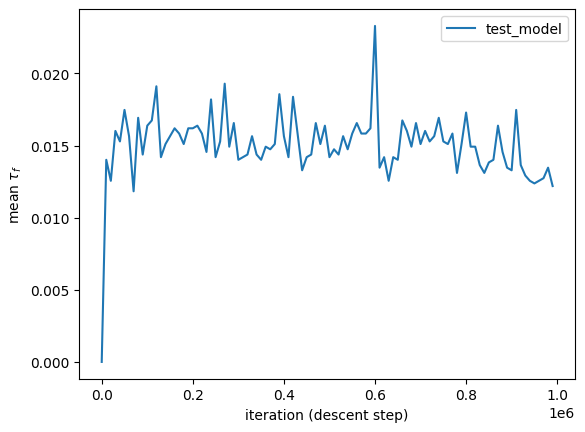

In [11]:
plt.plot(iters, tau, label="test_model")
plt.xlabel('iteration (descent step)')
plt.ylabel(r'mean $\tau_f$')
plt.legend()
plt.savefig(f'{model.save_folder}/iter_vs_mean_tau_f.png')

In [ ]:
plt.hist(tau_f_se, density=True)
plt.xlabel(r'$\tau_f$ (NN)')
plt.savefig('../data/plots/tau_f_NN.png')
# plt.title(f'training_data_size={N}')

In [ ]:
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(train.T.reshape(-1, 3, 800))

plt.hist(tau_f_se)
plt.xlabel(r'$\tau_f$ (NN), for train data')
plt.title(f'training_data_size={N}')

In [ ]:
tau_f_se.mean()

In [ ]:
for batch, (X, y) in enumerate(train_dataloader):
    print(X, y)

In [ ]:
fig, N, dt = plt.figure(figsize=(8, 8)), 500, 0.02
t = np.arange(0., N*dt, dt) / (1/0.91)
axs = [fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)]
dims = ['x', 'y', 'z']
u = np.load('{}/validation.npy'.format(L63_data_path)).astype(np.float32)
u = train
idx = [[4, 14, 18], [13, 17, 46], [13, 2, 31], ]
labels = ['good', 'medium', 'bad']
predicted = model.multistep_forecast(u[:, 0], N)
for i, ax in enumerate(axs):
    ax.plot(t, u[i, :N], label='truth')
    ax.plot(t, predicted[i, :N], label='network')
    ax.legend(loc='upper right')
    if i == len(dims)-1:
        ax.set_xlabel('t')
    ax.set_ylabel(dims[i])